In [ ]:
# default_exp models.esrnn.esrnn

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# ES-RNN: Exponential Smoothing Recurrent Neural Network

> API details.

The winning submission of the M4 competition was the <em>Exponential Smoothing Recurrent Neural Network</em> (ESRNN). This hybrid model combined and simultaneously optimized the standard exponential smoothing method as a preprocessing component for the inputs of recurrent neural networks. The [original model](https://github.com/Mcompetitions/M4-methods/tree/master/118%20-%20slaweks17) is implemented in dynet.

[Slawek Smyl. A hybrid method of exponential smoothing and recurrent neural networks for time series forecasting. International Journal of Forecasting, 07 2019.](https://www.sciencedirect.com/science/article/pii/S0169207019301153)

In [ ]:
#export
from typing import Union, List

import numpy as np
import pytorch_lightning as pl
import torch as t
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

from nixtla.models.esrnn.esrnn_model import (
    _ES, _ESI, _MedianResidual, 
    _ESM, _RNN, _ESRNN
)
from nixtla.losses.utils import LossFunction

In [ ]:
#export
class ESRNN(pl.LightningModule):
    def __init__(self, n_series: int,
                 n_x: int, n_s: int, 
                 input_size: int, output_size: int,
                 idx_to_sample_freq: int,
                 es_component: str = 'multiplicative', 
                 cell_type: str = 'LSTM', state_hsize: int = 50, 
                 dilations: List[List[int]] = [[1, 2], [4, 8]], 
                 add_nl_layer: bool = False, seasonality: List[int] = [],
                 learning_rate: float = 1e-3, lr_scheduler_step_size: int = 9,
                 lr_decay: float = 0.9, per_series_lr_multip: float = 1.,
                 gradient_eps: float = 1e-8, 
                 gradient_clipping_threshold: float = 20.,
                 rnn_weight_decay: float = 0., noise_std: float = 1e-3,
                 level_variability_penalty: float = 20.,
                 testing_percentile: Union[int, List] = 50, 
                 training_percentile: Union[int, List] = 50,
                 loss: str = 'SMYL', val_loss: str = 'MAE'):
        super(ESRNN, self).__init__()
        """ Exponential Smoothing Recurrent Neural Network

        Pytorch Implementation of the M4 time series forecasting competition winner.
        Proposed by Smyl. The model uses a hybrid approach of Machine Learning and
        statistical methods by combining recurrent neural networks to model a common
        trend with shared parameters across series, and multiplicative Holt-Winter
        exponential smoothing.

        Parameters
        ----------
        n_series: int
            Number of time series.
        n_x: int
            Number of temporal exogenous variables.
        n_s: int
            Number of static variables.
        input_size: int
            input size of the recurrent neural network, usually a
            multiple of seasonality
        output_size: int
            output_size or forecast horizon of the recurrent neural
            network, usually multiple of seasonality
        idx_to_sample_freq: int
            Step size between windows.
        es_component: str
            Exponential Smoothing component.
            Default multiplicative.
        cell_type: str
            Type of RNN cell, available GRU, LSTM, RNN, ResidualLSTM.
        state_hsize: int
            dimension of hidden state of the recurrent neural network
        dilations: int list
            each list represents one chunk of Dilated LSTMS, connected in
            standard ResNet fashion
        add_nl_layer: bool
            whether to insert a tanh() layer between the RNN stack and the
            linear adaptor (output) layers
        seasonality: int list
            list of seasonalities of the time series
            Hourly [24, 168], Daily [7], Weekly [52], Monthly [12],
            Quarterly [4], Yearly [].
        learning_rate: float
            size of the stochastic gradient descent steps
        lr_scheduler_step_size: int
            this step_size is the period for each learning rate decay
        lr_decay: float
            Learning rate decay.
        per_series_lr_multip: float
            multiplier for per-series parameters smoothing and initial
            seasonalities learning rate (default 1.0)
        gradient_eps: float
            term added to the Adam optimizer denominator to improve
            numerical stability (default: 1e-8)
        gradient_clipping_threshold: float
            max norm of gradient vector, with all parameters treated
            as a single vector
        rnn_weight_decay: float
            parameter to control classic L2/Tikhonov regularization
            of the rnn parameters
        noise_std: float
            standard deviation of white noise added to input during
            fit to avoid the model from memorizing the train data
        level_variability_penalty: float
            this parameter controls the strength of the penalization
            to the wigglines of the level vector, induces smoothness
            in the output
        testing_percentile: int
            This value is only for diagnostic evaluation.
            In case of percentile predictions this parameter controls
            for the value predicted, when forecasting point value,
            the forecast is the median, so percentile=50.
        training_percentile: float
            To reduce the model's tendency to over estimate, the
            training_percentile can be set to fit a smaller value
            through the Pinball Loss.
        loss: str
            Loss used to train.
        val_loss: str
            Loss used to validate.
        
        Notes
        -----
        **References:**
        `M4 Competition Conclusions
        <https://rpubs.com/fotpetr/m4competition>`__
        `Original Dynet Implementation of ESRNN
        <https://github.com/M4Competition/M4-methods/tree/master/118%20-%20slaweks17>`__
        """

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.n_series = n_series
        self.n_x = n_x
        self.n_s = n_s 
        self.idx_to_sample_freq = idx_to_sample_freq
        self.input_size = input_size
        self.output_size = output_size
        self.es_component = es_component
        self.cell_type = cell_type
        self.state_hsize = state_hsize
        self.dilations = dilations
        self.add_nl_layer = add_nl_layer
        self.seasonality = seasonality

        # Regularization and optimization parameters
        self.learning_rate = learning_rate
        self.lr_scheduler_step_size = lr_scheduler_step_size
        self.lr_decay = lr_decay
        self.per_series_lr_multip = per_series_lr_multip
        self.gradient_eps = gradient_eps
        self.gradient_clipping_threshold = gradient_clipping_threshold
        self.rnn_weight_decay = rnn_weight_decay
        self.noise_std = noise_std
        self.level_variability_penalty = level_variability_penalty
        self.testing_percentile = testing_percentile
        self.training_percentile = training_percentile
        self.loss = loss
        self.val_loss = val_loss
        self.loss_fn = LossFunction(loss, 
                                    percentile=self.training_percentile,
                                    level_variability_penalty=self.level_variability_penalty)
        self.val_loss_fn = LossFunction(val_loss,
                                        percentile=self.testing_percentile,
                                        level_variability_penalty=self.level_variability_penalty)

        # MQESRNN
        self.mq = isinstance(self.training_percentile, list)
        self.output_size_m = len(self.training_percentile) if self.mq else 1

        #Defining model
        self.esrnn = _ESRNN(n_series=self.n_series, 
                            input_size=self.input_size,
                            output_size=self.output_size, 
                            output_size_m=self.output_size_m,
                            n_t=self.n_x, n_s=self.n_s,
                            es_component=self.es_component, 
                            seasonality=self.seasonality,
                            noise_std=self.noise_std, 
                            cell_type=self.cell_type,
                            dilations=self.dilations, 
                            state_hsize=self.state_hsize,
                            add_nl_layer=self.add_nl_layer,
                            device=self.device).to(self.device)
        
        self.automatic_optimization = False
            
    def training_step(self, batch, batch_idx):
        es_opt, rnn_opt = self.optimizers()
        
        #Parsing batch
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        idxs = batch['idxs']
    
        target, forecast, levels = self.esrnn(S=S, Y=Y, X=X, idxs=idxs, 
                                              step_size=self.idx_to_sample_freq)
        loss = self.loss_fn(y=forecast,
                            y_hat=target,
                            y_insample=Y, 
                            levels=levels) 
        
        es_opt.zero_grad()
        rnn_opt.zero_grad()
        self.manual_backward(loss)
        clip_grad_norm_(parameters=self.esrnn.rnn.parameters(),
                        max_norm=self.gradient_clipping_threshold)
        clip_grad_norm_(parameters=self.esrnn.es.parameters(),
                        max_norm=self.gradient_clipping_threshold)
        es_opt.step()
        rnn_opt.step()

        self.log('train_loss', loss)
        
        return loss
    
    def on_train_epoch_end(self):
        for lr_scheduler in self.lr_schedulers():
            lr_scheduler.step()
    
    def validation_step(self, batch, idx):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        idxs = batch['idxs']
        
        target, forecast = self.esrnn.predict(S=S, Y=Y, X=X, idxs=idxs,
                                              step_size=self.idx_to_sample_freq)
        loss = self.val_loss_fn(y=forecast,
                                y_hat=target,
                                y_insample=Y)
        self.log('val_loss', loss)
        
        return loss
    
    def forward(self, batch):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        idxs = batch['idxs']
        
        target, forecast = self.esrnn.predict(S=S, Y=Y, X=X, idxs=idxs,
                                              step_size=self.idx_to_sample_freq)
        
        return target, forecast
    
    def configure_optimizers(self):
        es_optimizer = Adam(params=self.esrnn.es.parameters(),
                            lr=self.learning_rate * self.per_series_lr_multip,
                            eps=self.gradient_eps)
        rnn_optimizer = Adam(params=self.esrnn.rnn.parameters(),
                             lr=self.learning_rate,
                             eps=self.gradient_eps,
                             weight_decay=self.rnn_weight_decay)
        
        lr_es = StepLR(optimizer=es_optimizer,
                       step_size=self.lr_scheduler_step_size,
                       gamma=self.lr_decay)
        lr_rnn = StepLR(optimizer=rnn_optimizer,
                        step_size=self.lr_scheduler_step_size,
                        gamma=self.lr_decay)
        
        return [es_optimizer, rnn_optimizer], [lr_es, lr_rnn]

## ES-RNN Univariate Example

In [ ]:
import matplotlib.pyplot as plt

from nixtla.data.datasets.epf import EPF, EPFInfo
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader import TimeSeriesLoader

In [ ]:
Y_df, X_df, _ = EPF.load(directory='./data', group=EPFInfo.groups[0])

X_df = X_df[['unique_id', 'ds', 'week_day']]

# Leveling Y_df (multiplicative model)
Y_min = Y_df.y.min()
Y_df.y = Y_df.y - Y_min + 20

train_ts_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df,
                                     ds_in_test=728*24,
                                     mode='full',
                                     window_sampling_limit= 500_000, # To limit backprop time
                                     input_size=7*24,
                                     output_size=24,
                                     idx_to_sample_freq=24,
                                     len_sample_chunks=3*7*24,
                                     complete_inputs=True)

outsample_ts_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df,
                                         ds_in_test=728*24, 
                                         is_test=True,
                                         mode='full',
                                         window_sampling_limit= 500_000, 
                                         input_size=7*24,
                                         output_size=24,
                                         idx_to_sample_freq=24,
                                         len_sample_chunks=4*7*24,
                                         complete_inputs=False,
                                         complete_outputs=False)

train_ts_loader = TimeSeriesLoader(dataset=train_ts_dataset,
                                   batch_size=32, 
                                   shuffle=True)

val_ts_loader = TimeSeriesLoader(dataset=outsample_ts_dataset,
                                 batch_size=1,
                                 shuffle=False)

In [ ]:
model = ESRNN(# Architecture parameters
              n_series=train_ts_dataset.n_series,
              n_s=train_ts_dataset.n_s,
              n_x=train_ts_dataset.n_x,
              input_size=train_ts_dataset.input_size,
              output_size=train_ts_dataset.output_size,
              idx_to_sample_freq=train_ts_dataset.idx_to_sample_freq,
              es_component='multiplicative',
              cell_type='LSTM',
              state_hsize=50,
              dilations=[[1, 2], [7, 14]],
              add_nl_layer=False,
              # Regularization and optimization parameters
              learning_rate=5e-3,
              lr_scheduler_step_size=100,
              lr_decay=0.9,
              per_series_lr_multip=1.5,
              gradient_eps=1e-8,
              gradient_clipping_threshold=10,
              rnn_weight_decay=0,
              noise_std=0.001,
              level_variability_penalty=10,
              testing_percentile=50,
              training_percentile=51,
              loss='SMYL',
              val_loss='MAE',
              seasonality=[24]) 

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", 
                               min_delta=1e-4, 
                               patience=1, verbose=True, 
                               mode="min")

In [ ]:
trainer = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=1, 
                     log_every_n_steps=1, check_val_every_n_epoch=1,
                     callbacks=[early_stopping])
trainer.fit(model, train_ts_loader, val_ts_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type   | Params
---------------------------------
0 | esrnn | _ESRNN | 144 K 
---------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total params
0.579     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 3.529


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.055 >= min_delta = 0.0001. New best score: 3.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.297 >= min_delta = 0.0001. New best score: 3.178


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.202 >= min_delta = 0.0001. New best score: 2.976


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.054 >= min_delta = 0.0001. New best score: 2.922


In [ ]:
outputs = trainer.predict(model, val_ts_loader)

y, y_hat = zip(*outputs)
y = t.cat(y)
y_hat = t.cat(y_hat)

/home/federicogarza2/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Predicting: 1it [00:00, ?it/s]

In [ ]:
# Returning level to Y_df and Y_hat_df
y = y + Y_min - 20
y_hat = y_hat + Y_min - 20

In [ ]:
from scipy import stats

import pandas as pd

from nixtla.losses.numpy import mae, rmae, smape, rmse
from nixtla.data.datasets.epf import epf_naive_forecast

Y_naive_df = epf_naive_forecast(Y_df)

y_true = y[-728*24:, -1]
y_hat = y_hat[-728*24:, -1]
y_naive = Y_naive_df.y_hat.values[-728*24:]

print("Original")
print("y_true.shape", y_true.shape)
print("y_hat.shape", y_hat.shape)
y_true = y_true.flatten()
y_hat = y_hat.flatten()
print("\nFlatten")
print("y_true.shape", y_true.shape)
print("y_hat.shape", y_hat.shape)
print("y_naive.shape", y_naive.shape)

metrics = pd.Series({'mae' : mae(y=y_true, y_hat=y_hat),
                     'rmae': rmae(y=y_true, y_hat1=y_hat, y_hat2=y_naive),
                     'smape': smape(y=y_true, y_hat=y_hat),
                     'rmse': rmse(y=y_true, y_hat=y_hat)})

print(Y_df.unique_id[0])
print(metrics)
print('\n')
print(stats.describe(y_true-y_hat))
print(f'model.training_percentile {model.training_percentile}')

Original
y_true.shape torch.Size([728, 24])
y_hat.shape torch.Size([728, 24])

Flatten
y_true.shape torch.Size([17472])
y_hat.shape torch.Size([17472])
y_naive.shape (17472,)
NP
mae      3.122829
rmae     0.165082
smape    8.918972
rmse     4.971871
dtype: float64


DescribeResult(nobs=17472, minmax=(-40.61875, 144.19559), mean=0.3779371, variance=24.578072, skewness=2.6203927993774414, kurtosis=56.27131781220594)
model.training_percentile 51


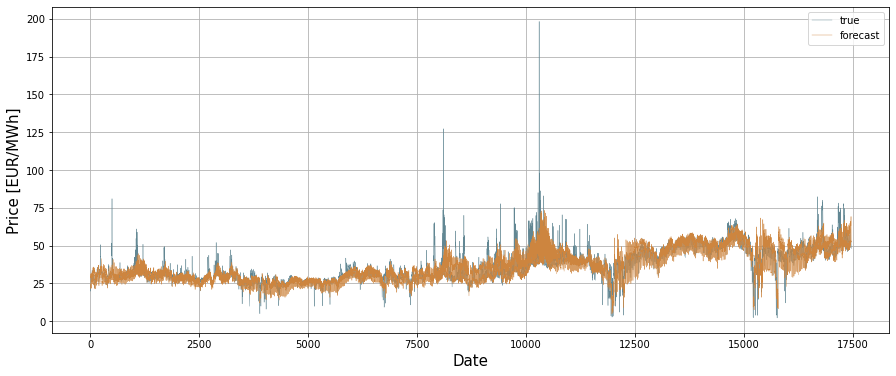

In [ ]:
start = 0
end = 728 * 24

# start = 365
# end = 365 + (4*7*24)

fig = plt.figure(figsize=(15, 6))
plt.plot(y_true[start:end], color='#628793', linewidth=0.4, label='true')
plt.plot(y_hat[start:end], color='peru', linewidth=0.4, label='forecast')
plt.ylabel('Price [EUR/MWh]', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.legend()
plt.grid()
# plt.savefig('./results/NP.png', bbox_inches = 'tight')
plt.show()

## ES-RNN Multivariate Example

In [ ]:
from nixtla.data.datasets.tourism import Tourism, TourismInfo
print(TourismInfo.groups[0])
Y_df, *_ = Tourism.load(directory='./data', group=TourismInfo.groups[0])

Yearly


In [ ]:
train_ts_dataset = TimeSeriesDataset(Y_df=Y_df,
                                     ds_in_test=6,
                                     mode='full',
                                     window_sampling_limit=500_000, # To limit backprop time
                                     input_size=4,
                                     output_size=4,
                                     idx_to_sample_freq=1,
                                     len_sample_chunks=11,
                                     complete_inputs=True, 
                                     complete_outputs=False,
                                     skip_nonsamplable=True)

outsample_ts_dataset = TimeSeriesDataset(Y_df=Y_df, 
                                         ds_in_test=0,
                                         mode='full',
                                         window_sampling_limit=500_000, # To limit backprop time
                                         input_size=4,
                                         output_size=4,
                                         idx_to_sample_freq=1,
                                         len_sample_chunks=11,
                                         complete_inputs=True, 
                                         complete_outputs=True,
                                         skip_nonsamplable=False)

In [ ]:
train_ts_loader = TimeSeriesLoader(dataset=train_ts_dataset,
                                   batch_size=32,
                                   eq_batch_size=True,
                                   shuffle=True)

val_ts_loader = TimeSeriesLoader(dataset=outsample_ts_dataset,
                                 batch_size=1,
                                 shuffle=False)

In [ ]:
dataloader = iter(train_ts_loader)
batch = next(dataloader)
S, Y, X = batch['S'], batch['Y'], batch['X']
available_mask = batch['available_mask']
idxs = batch['idxs']

print("S.shape", S.shape)
print("Y.shape", Y.shape)
print("X.shape", X.shape)
print("idxs.shape", idxs.shape)

S.shape torch.Size([32, 0])
Y.shape torch.Size([32, 11])
X.shape torch.Size([32, 0, 11])
idxs.shape torch.Size([32])


In [ ]:
model = ESRNN(n_series=train_ts_dataset.n_series,
              n_s=train_ts_dataset.n_s,
              n_x=train_ts_dataset.n_x,
              input_size=train_ts_dataset.input_size,
              output_size=train_ts_dataset.output_size,
              idx_to_sample_freq=train_ts_dataset.idx_to_sample_freq,
              learning_rate=5e-3,
              lr_scheduler_step_size=100,
              lr_decay=0.9,
              per_series_lr_multip=1.5,
              gradient_eps=1e-8,
              gradient_clipping_threshold=10,
              rnn_weight_decay=0,
              noise_std=0.001,
              level_variability_penalty=10,
              testing_percentile=50,
              training_percentile=51,
              es_component='multiplicative',
              cell_type='GRU',
              state_hsize=50,
              dilations=[[24, 48], [168]],
              add_nl_layer=False,
              loss='SMYL',
              val_loss='MAE',
              seasonality=[1]) 

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", 
                               min_delta=1e-4, 
                               patience=1, verbose=True, 
                               mode="min")

In [ ]:
trainer = pl.Trainer(max_epochs=2, progress_bar_refresh_rate=1, 
                     log_every_n_steps=1, check_val_every_n_epoch=1,
                     callbacks=[early_stopping])
trainer.fit(model, train_ts_loader, val_ts_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type   | Params
---------------------------------
0 | esrnn | _ESRNN | 40.8 K
---------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/federicogarza2/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/federicogarza2/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 26553.766


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 1 records. Best score: 26553.766. Signaling Trainer to stop.


In [ ]:
outputs = trainer.predict(model, val_ts_loader)
y, y_hat = zip(*outputs)
y = t.cat(y)
y_hat = t.cat(y_hat)
print("y_true.shape", y.shape)
print("y_hat.shape", y_hat.shape)

Predicting: 1it [00:00, ?it/s]

y_true.shape torch.Size([7498, 4, 4])
y_hat.shape torch.Size([7498, 4, 4])
